## Module 18: Learning Notebook 2: More KMeans

OK, we did a simple 2-feature KMeans. But that is not realistic. Let's use all the features in the dataset.<BR>
   
There is no practial limit to the number of features to use in KMeans clustering.

In [2]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
import boto3
import pandas as pd
import numpy as np
import seaborn as sns

### 1. Load and investigate data

In [3]:
# Load from S3
sess = boto3.session.Session()
s3 = sess.client('s3') 
source_bucket = 'machinelearning-read-only'
source_key = 'data/mall_customers.csv' 
response = s3.get_object(Bucket = source_bucket, Key = source_key)
df = pd.read_csv(response.get("Body"))
print('df size (rows, columns):',df.shape)
# 4 features to cluster
df.head(3)

df size (rows, columns): (200, 4)


,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6


### 2. Clean up the Gender column

In [4]:
# Load the data into the X variable
X = df
# Use the colum transformer we used before
category_columns = ['Gender']
category_ct = ColumnTransformer(
    transformers = [
    ('cat', OrdinalEncoder(categories = [['Male','Female']], dtype = int), category_columns)
    ],
    remainder = 'passthrough')

# Prepare the ct to transform the data
category_ct.fit(X)
# perform the transformation
transformed_array = category_ct.transform(X)
# Overwrite the X['Gender'] column
X['Gender'] = transformed_array
X.head()

,Gender,Age,Annual_Income,Spending_Score
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


### 3. Now, let's first determine the best k

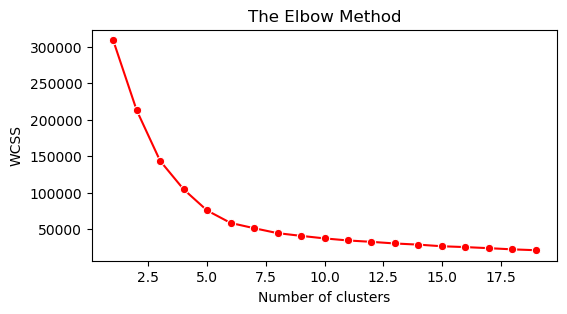

In [5]:
# Using the elbow method to find the optimal number of clusters
wcss = [] # This will be the "Within Cluster Sum of Squares" a performance metric
for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model. We want minimize this with the fewest clusters.
    wcss.append(kmeans.inertia_)
# Plot
plt.figure(figsize=(6,3))
sns.lineplot(range(1, 20), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### 4. Perform KMeans with your selected number of clusters

In [6]:
# Use KMeans with  k = ?
kmeans = KMeans(n_clusters = 6, random_state=42)
kmeans.fit(X)
y_pred = kmeans.predict(X)
y_pred_df = pd.DataFrame(data = y_pred, columns = ['predicted_cluster'])
result_df = pd.concat([X, y_pred_df], axis=1)
result_df.head()

,Gender,Age,Annual_Income,Spending_Score,predicted_cluster
0,0,19,15,39,0
1,0,21,15,81,1
2,1,20,16,6,0
3,1,23,16,77,1
4,1,31,17,40,0


In [7]:
# We can't visualize 4 dimensions, but now you understand how KMeans clusters
result_df['predicted_cluster'].value_counts() # How many are in each cluster?

3    45
4    39
5    38
2    35
1    22
0    21
Name: predicted_cluster, dtype: int64